In [1]:
# EMG Gesture Recognition System
# For ESP32-S3 with Gravity Analog EMG Sensor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.stats import skew, kurtosis
import os
import glob
import pickle
import warnings
warnings.filterwarnings('ignore')

# Machine Learning imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
import joblib

In [2]:
# %% [markdown]
# ## 1. Data Loading and Exploration

def load_emg_data(data_folder='data/'):
    """Load all EMG data files from the specified folder"""
    all_data = []
    
    # Get all txt files
    file_pattern = os.path.join(data_folder, '*.txt')
    files = glob.glob(file_pattern)
    
    for file_path in files:
        filename = os.path.basename(file_path)
        print(f"Loading {filename}...")
        
        # Read the file
        with open(file_path, 'r') as f:
            lines = f.readlines()
        
        # Parse each line
        for line in lines:
            if line.strip():
                parts = line.strip().split(',')
                if len(parts) >= 3:
                    all_data.append({
                        'timestamp': float(parts[0]),
                        'value': float(parts[1]),
                        'label': int(parts[2]),
                        'filename': filename
                    })
    
    df = pd.DataFrame(all_data)
    return df

# Load data
df = load_emg_data('data/')
print(f"\nTotal samples loaded: {len(df)}")
print(f"Pinch samples (label=2): {len(df[df['label']==2])}")
print(f"Rotate samples (label=1): {len(df[df['label']==1])}")
print(f"\nData statistics:")
print(df.describe())

Loading pinch1.txt...
Loading pinch2.txt...
Loading pinch3.txt...
Loading pinch4.txt...
Loading pinch5.txt...
Loading pinch6.txt...
Loading rotate1.txt...
Loading rotate2.txt...
Loading rotate3.txt...
Loading rotate4.txt...
Loading rotate5.txt...
Loading rotate6.txt...
Loading rotate7.txt...

Total samples loaded: 195000
Pinch samples (label=2): 90000
Rotate samples (label=1): 105000

Data statistics:
          timestamp          value          label
count  1.950000e+05  195000.000000  195000.000000
mean   1.754630e+12    1760.996092       1.461538
std    3.306157e+06      46.348731       0.498520
min    1.754626e+12      16.000000       1.000000
25%    1.754627e+12    1741.000000       1.000000
50%    1.754631e+12    1763.000000       1.000000
75%    1.754633e+12    1782.000000       2.000000
max    1.754634e+12    3794.000000       2.000000


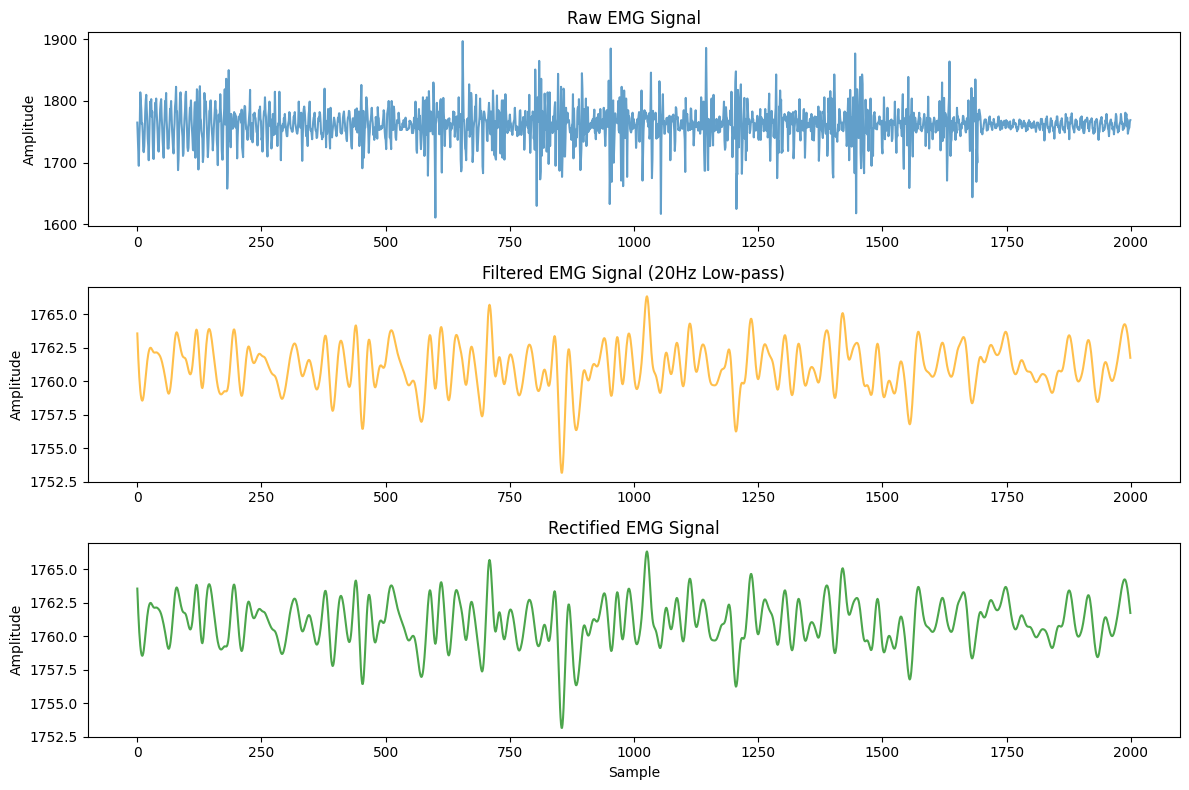

In [3]:
# %% [markdown]
# ## 2. Signal Preprocessing and Filtering

class EMGPreprocessor:
    def __init__(self, sampling_freq=500):
        self.fs = sampling_freq
        
    def butter_bandpass(self, lowcut, highcut, order=4):
        """Create Butterworth bandpass filter"""
        nyq = 0.5 * self.fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = signal.butter(order, [low, high], btype='band')
        return b, a
    
    def butter_lowpass(self, cutoff, order=4):
        """Create Butterworth lowpass filter"""
        nyq = 0.5 * self.fs
        normal_cutoff = cutoff / nyq
        b, a = signal.butter(order, normal_cutoff, btype='low')
        return b, a
    
    def apply_filter(self, data, filter_type='bandpass', lowcut=20, highcut=450):
        """Apply filter to EMG signal"""
        if filter_type == 'bandpass':
            b, a = self.butter_bandpass(lowcut, highcut)
        else:  # lowpass
            b, a = self.butter_lowpass(lowcut)
        
        filtered = signal.filtfilt(b, a, data)
        return filtered
    
    def remove_dc_offset(self, data):
        """Remove DC offset from signal"""
        return data - np.mean(data)
    
    def rectify(self, data):
        """Full-wave rectification"""
        return np.abs(data)
    
    def moving_average(self, data, window_size=50):
        """Apply moving average smoothing"""
        return np.convolve(data, np.ones(window_size)/window_size, mode='same')

# Initialize preprocessor
preprocessor = EMGPreprocessor(sampling_freq=500)

# Apply preprocessing to the entire dataset
df['filtered_value'] = preprocessor.apply_filter(df['value'].values, 'lowpass', 20)
df['rectified'] = preprocessor.rectify(df['filtered_value'].values)

# Visualize preprocessing effects
fig, axes = plt.subplots(3, 1, figsize=(12, 8))

sample_size = 2000
axes[0].plot(df['value'][:sample_size], alpha=0.7)
axes[0].set_title('Raw EMG Signal')
axes[0].set_ylabel('Amplitude')

axes[1].plot(df['filtered_value'][:sample_size], alpha=0.7, color='orange')
axes[1].set_title('Filtered EMG Signal (20Hz Low-pass)')
axes[1].set_ylabel('Amplitude')

axes[2].plot(df['rectified'][:sample_size], alpha=0.7, color='green')
axes[2].set_title('Rectified EMG Signal')
axes[2].set_ylabel('Amplitude')
axes[2].set_xlabel('Sample')

plt.tight_layout()
plt.show()


In [4]:
# %% [markdown]
# ## 3. Feature Extraction

class FeatureExtractor:
    def __init__(self, window_size=50, step_size=10):
        self.window_size = window_size
        self.step_size = step_size
    
    def extract_time_domain_features(self, window):
        """Extract time-domain features from EMG window"""
        features = {}
        
        # Statistical features
        features['mean'] = np.mean(window)
        features['std'] = np.std(window)
        features['var'] = np.var(window)
        features['rms'] = np.sqrt(np.mean(window**2))
        features['mad'] = np.mean(np.abs(window - np.mean(window)))
        
        # Mean Absolute Value (MAV)
        features['mav'] = np.mean(np.abs(window))
        
        # Zero Crossing Rate (ZCR)
        zero_crossings = np.where(np.diff(np.sign(window)))[0]
        features['zcr'] = len(zero_crossings)
        
        # Slope Sign Changes (SSC)
        diff = np.diff(window)
        ssc = np.sum(diff[:-1] * diff[1:] < 0)
        features['ssc'] = ssc
        
        # Waveform Length (WL)
        features['wl'] = np.sum(np.abs(np.diff(window)))
        
        # Willison Amplitude (WAMP)
        threshold = 0.05 * np.max(np.abs(window))
        features['wamp'] = np.sum(np.abs(np.diff(window)) > threshold)
        
        # Higher order statistics
        features['skewness'] = skew(window)
        features['kurtosis'] = kurtosis(window)
        
        # Percentiles
        features['p25'] = np.percentile(window, 25)
        features['p50'] = np.percentile(window, 50)
        features['p75'] = np.percentile(window, 75)
        features['iqr'] = features['p75'] - features['p25']
        
        # Energy
        features['energy'] = np.sum(window**2)
        
        # Peak-to-peak amplitude
        features['peak_to_peak'] = np.max(window) - np.min(window)
        
        return features
    
    def extract_frequency_domain_features(self, window, fs=500):
        """Extract frequency-domain features using FFT"""
        features = {}
        
        # Compute FFT
        fft_vals = np.fft.rfft(window)
        fft_freqs = np.fft.rfftfreq(len(window), 1/fs)
        magnitude = np.abs(fft_vals)
        
        # Mean frequency
        features['mean_freq'] = np.sum(fft_freqs * magnitude) / np.sum(magnitude)
        
        # Median frequency
        cumsum = np.cumsum(magnitude)
        features['median_freq'] = fft_freqs[np.where(cumsum >= cumsum[-1]/2)[0][0]]
        
        # Peak frequency
        features['peak_freq'] = fft_freqs[np.argmax(magnitude)]
        
        # Band power (0-50Hz, 50-150Hz, 150-250Hz, 250-500Hz)
        bands = [(0, 50), (50, 150), (150, 250), (250, 500)]
        for i, (low, high) in enumerate(bands):
            band_idx = np.where((fft_freqs >= low) & (fft_freqs < high))
            features[f'band_power_{i}'] = np.sum(magnitude[band_idx]**2)
        
        return features
    
    def create_feature_dataset(self, data, labels):
        """Create windowed feature dataset"""
        feature_list = []
        label_list = []
        
        for i in range(0, len(data) - self.window_size, self.step_size):
            window = data[i:i + self.window_size]
            window_labels = labels[i:i + self.window_size]
            
            # Use majority voting for label
            label = np.bincount(window_labels).argmax()
            
            # Extract features
            time_features = self.extract_time_domain_features(window)
            freq_features = self.extract_frequency_domain_features(window)
            
            # Combine features
            all_features = {**time_features, **freq_features}
            
            feature_list.append(all_features)
            label_list.append(label)
        
        return pd.DataFrame(feature_list), np.array(label_list)

# Extract features
extractor = FeatureExtractor(window_size=50, step_size=10)
X, y = extractor.create_feature_dataset(
    df['filtered_value'].values,
    df['label'].values
)

print(f"Feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"\nFeature names: {list(X.columns)}")

# Convert labels: 1 (rotate) -> 0, 2 (pinch) -> 1
y_binary = (y == 2).astype(int)


Feature matrix shape: (19495, 25)
Labels shape: (19495,)
Number of features: 25

Feature names: ['mean', 'std', 'var', 'rms', 'mad', 'mav', 'zcr', 'ssc', 'wl', 'wamp', 'skewness', 'kurtosis', 'p25', 'p50', 'p75', 'iqr', 'energy', 'peak_to_peak', 'mean_freq', 'median_freq', 'peak_freq', 'band_power_0', 'band_power_1', 'band_power_2', 'band_power_3']


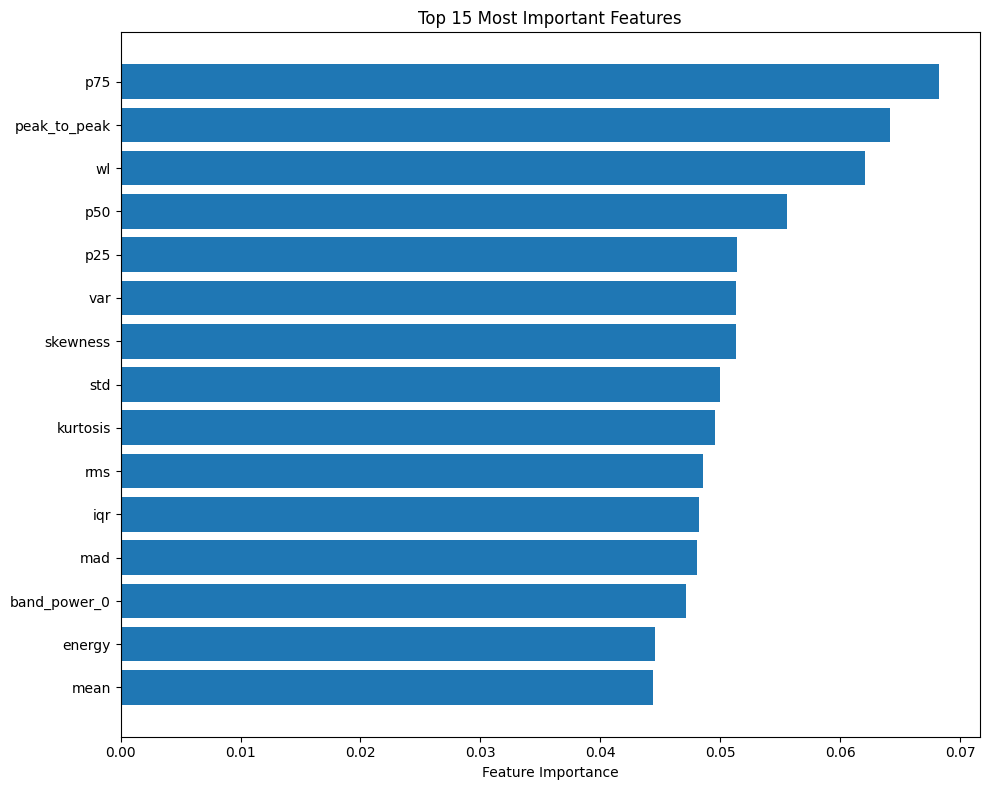

Top 10 features:
         feature  importance
14           p75    0.068237
17  peak_to_peak    0.064171
8             wl    0.062090
13           p50    0.055558
12           p25    0.051430
2            var    0.051330
10      skewness    0.051309
1            std    0.049989
11      kurtosis    0.049530
3            rms    0.048572


In [5]:
# %% [markdown]
# ## 4. Feature Selection and Visualization

# Visualize feature importance using Random Forest
rf_temp = RandomForestClassifier(n_estimators=100, random_state=42)
rf_temp.fit(X, y_binary)

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_temp.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'][:15], feature_importance['importance'][:15])
plt.xlabel('Feature Importance')
plt.title('Top 15 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Top 10 features:")
print(feature_importance.head(10))

# Select top features
top_features = feature_importance['feature'][:15].values
X_selected = X[top_features]

In [6]:
# ## 5. Model Training and Evaluation

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Dictionary to store models and results
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Use scaled data for SVM, NN, and KNN
    if name in ['SVM', 'Neural Network', 'KNN']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    
    # Cross-validation
    if name in ['SVM', 'Neural Network', 'KNN']:
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    else:
        cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred,
        'probabilities': y_prob
    }
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Cross-validation: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Rotate', 'Pinch']))



Training Random Forest...
Accuracy: 0.6745
Cross-validation: 0.6700 (+/- 0.0076)

Classification Report:
              precision    recall  f1-score   support

      Rotate       0.71      0.67      0.69      2099
       Pinch       0.64      0.68      0.66      1800

    accuracy                           0.67      3899
   macro avg       0.67      0.67      0.67      3899
weighted avg       0.68      0.67      0.67      3899


Training Gradient Boosting...
Accuracy: 0.6707
Cross-validation: 0.6659 (+/- 0.0093)

Classification Report:
              precision    recall  f1-score   support

      Rotate       0.70      0.68      0.69      2099
       Pinch       0.64      0.66      0.65      1800

    accuracy                           0.67      3899
   macro avg       0.67      0.67      0.67      3899
weighted avg       0.67      0.67      0.67      3899


Training SVM...
Accuracy: 0.6561
Cross-validation: 0.6578 (+/- 0.0078)

Classification Report:
              precision    recall 


Model Comparison:
               Model  Test Accuracy   CV Mean    CV Std
0      Random Forest       0.674532  0.670043  0.007566
1  Gradient Boosting       0.670685  0.665876  0.009329
3     Neural Network       0.657605  0.660426  0.007500
2                SVM       0.656066  0.657796  0.007827
4                KNN       0.626827  0.624134  0.001715


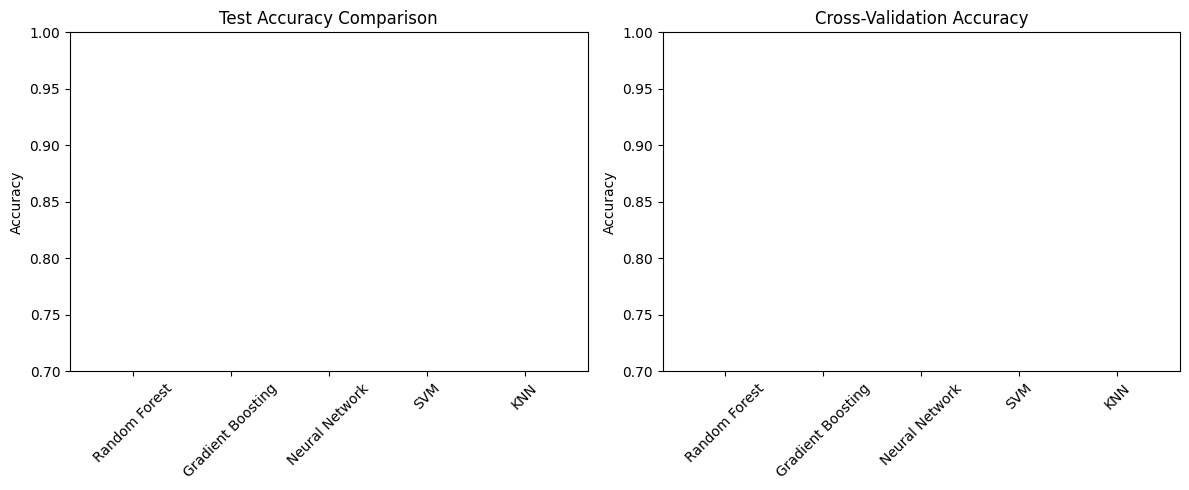


Best model: Random Forest


In [7]:
# ## 6. Model Comparison and Selection

# Compare models
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Test Accuracy': [results[m]['accuracy'] for m in results],
    'CV Mean': [results[m]['cv_mean'] for m in results],
    'CV Std': [results[m]['cv_std'] for m in results]
}).sort_values('Test Accuracy', ascending=False)

print("\nModel Comparison:")
print(comparison_df)

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(comparison_df['Model'], comparison_df['Test Accuracy'])
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Test Accuracy Comparison')
axes[0].set_ylim([0.7, 1.0])
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(comparison_df['Model'], comparison_df['CV Mean'])
axes[1].errorbar(range(len(comparison_df)), comparison_df['CV Mean'], 
                 yerr=comparison_df['CV Std'], fmt='none', color='black', capsize=5)
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Cross-Validation Accuracy')
axes[1].set_ylim([0.7, 1.0])
axes[1].set_xticks(range(len(comparison_df)))
axes[1].set_xticklabels(comparison_df['Model'], rotation=45)

plt.tight_layout()
plt.show()

# Select best model
best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
print(f"\nBest model: {best_model_name}")


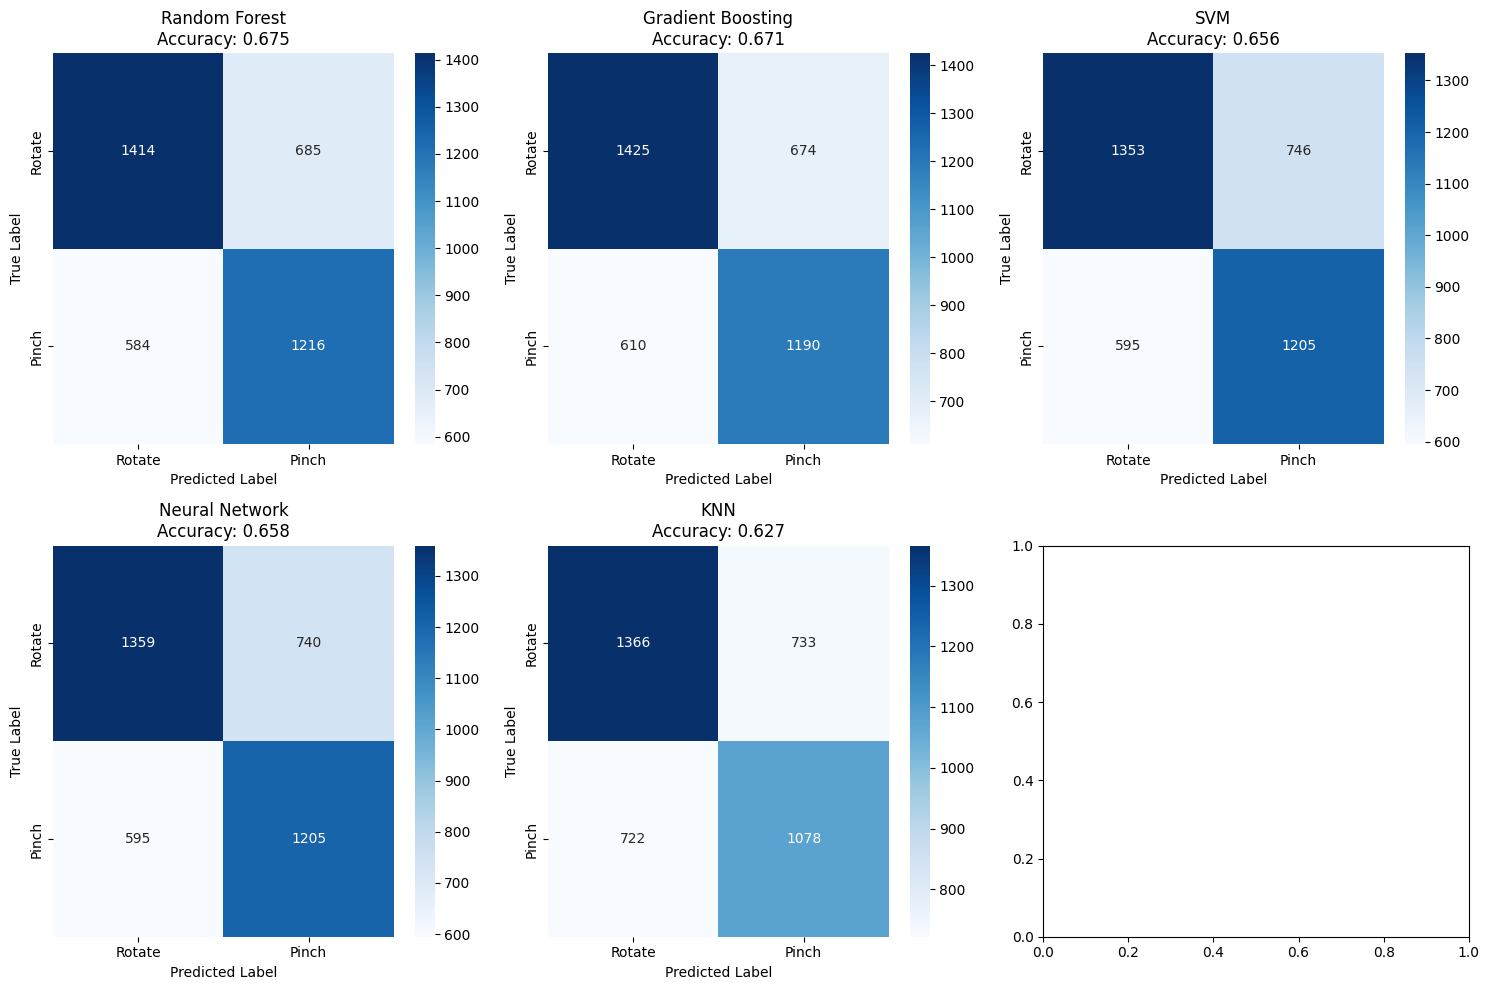

In [8]:
# ## 7. Confusion Matrix and Detailed Evaluation

# Plot confusion matrices for all models
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Rotate', 'Pinch'], yticklabels=['Rotate', 'Pinch'])
    axes[idx].set_title(f'{name}\nAccuracy: {result["accuracy"]:.3f}')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()


In [10]:
# ## 8. Save Best Model for Deployment

# Save the best model and preprocessing parameters
model_data = {
    'model': best_model,
    'scaler': scaler if best_model_name in ['SVM', 'Neural Network', 'KNN'] else None,
    'feature_names': top_features,
    'window_size': extractor.window_size,
    'step_size': extractor.step_size,
    'model_type': best_model_name
}

# Save with joblib (recommended for scikit-learn models)
joblib.dump(model_data, 'models/emg_gesture_model.pkl')
print(f"Model saved as 'models/emg_gesture_model.pkl'")

# Also save as separate components for flexibility
joblib.dump(best_model, 'models/best_model.pkl')
joblib.dump(scaler, 'models/scaler.pkl')
np.save('feature_names.npy', top_features)

print("Individual components saved:")
print("- best_model.pkl")
print("- scaler.pkl")
print("- feature_names.npy")


Model saved as 'models/emg_gesture_model.pkl'
Individual components saved:
- best_model.pkl
- scaler.pkl
- feature_names.npy


In [14]:
# ## 9. Real-time Prediction Function

def predict_gesture_realtime(emg_buffer, model_data):
    """
    Make real-time prediction from EMG buffer
    
    Args:
        emg_buffer: numpy array of EMG values (length = window_size)
        model_data: dictionary containing model and preprocessing parameters
    
    Returns:
        gesture: 'pinch' or 'rotate'
        confidence: probability of the predicted gesture
    """
    # Extract features
    extractor = FeatureExtractor(window_size=len(emg_buffer), step_size=1)
    features = extractor.extract_time_domain_features(emg_buffer)
    freq_features = extractor.extract_frequency_domain_features(emg_buffer)
    features.update(freq_features)
    
    # Create feature dataframe
    feature_df = pd.DataFrame([features])
    
    # Select relevant features
    feature_df = feature_df[model_data['feature_names']]
    
    # Scale if necessary
    if model_data['scaler'] is not None:
        feature_values = model_data['scaler'].transform(feature_df)
    else:
        feature_values = feature_df.values
    
    # Make prediction
    prediction = model_data['model'].predict(feature_values)[0]
    probability = model_data['model'].predict_proba(feature_values)[0]
    
    gesture = 'pinch' if prediction == 1 else 'rotate'
    confidence = probability[prediction]
    
    return gesture, confidence

# Test the real-time prediction function
test_buffer = df['filtered_value'].values[:50]  # Get a test window
loaded_model_data = joblib.load('models/emg_gesture_model.pkl')

gesture, confidence = predict_gesture_realtime(test_buffer, loaded_model_data)
print(f"\nTest prediction: {gesture} (confidence: {confidence:.2%})")



Test prediction: pinch (confidence: 68.73%)


In [15]:
# ## 10. ESP32 Integration Code

esp32_code = """
// ESP32-S3 EMG Gesture Recognition
// Using Gravity Analog EMG Sensor by OYMotion

#include <Arduino.h>

const int EMG_PIN = 34;  // Analog input pin
const int WINDOW_SIZE = 50;
const int STEP_SIZE = 10;
const int SAMPLING_RATE = 1000;  // Hz

float emg_buffer[WINDOW_SIZE];
int buffer_index = 0;

// Feature extraction functions
float calculate_mean(float* data, int len) {
    float sum = 0;
    for(int i = 0; i < len; i++) {
        sum += data[i];
    }
    return sum / len;
}

float calculate_std(float* data, int len) {
    float mean = calculate_mean(data, len);
    float sum = 0;
    for(int i = 0; i < len; i++) {
        sum += pow(data[i] - mean, 2);
    }
    return sqrt(sum / len);
}

float calculate_rms(float* data, int len) {
    float sum = 0;
    for(int i = 0; i < len; i++) {
        sum += pow(data[i], 2);
    }
    return sqrt(sum / len);
}

int calculate_zcr(float* data, int len) {
    int count = 0;
    for(int i = 1; i < len; i++) {
        if((data[i] >= 0 && data[i-1] < 0) || 
           (data[i] < 0 && data[i-1] >= 0)) {
            count++;
        }
    }
    return count;
}

void setup() {
    Serial.begin(115200);
    pinMode(EMG_PIN, INPUT);
}

void loop() {
    // Read EMG value
    int raw_value = analogRead(EMG_PIN);
    float emg_value = (raw_value / 4095.0) * 4000;  // Convert to 0-4000 range
    
    // Add to buffer
    emg_buffer[buffer_index] = emg_value;
    buffer_index = (buffer_index + 1) % WINDOW_SIZE;
    
    // Process when buffer is full
    if(buffer_index == 0) {
        // Extract features
        float mean = calculate_mean(emg_buffer, WINDOW_SIZE);
        float std = calculate_std(emg_buffer, WINDOW_SIZE);
        float rms = calculate_rms(emg_buffer, WINDOW_SIZE);
        int zcr = calculate_zcr(emg_buffer, WINDOW_SIZE);
        
        // Send features to serial for processing
        Serial.print("FEATURES:");
        Serial.print(mean); Serial.print(",");
        Serial.print(std); Serial.print(",");
        Serial.print(rms); Serial.print(",");
        Serial.print(zcr);
        Serial.println();
    }
    
    delay(1000 / SAMPLING_RATE);  // Maintain sampling rate
}
"""

print("\n" + "="*50)
print("ESP32 Integration Code saved in the script")
print("="*50)

# Save ESP32 code to file
with open('esp32_emg_gesture.ino', 'w') as f:
    f.write(esp32_code)
print("ESP32 code saved as 'esp32_emg_gesture.ino'")

print("\n✅ Complete EMG Gesture Recognition System Ready!")
print("\nNext steps:")
print("1. Upload the ESP32 code to your microcontroller")
print("2. Use the saved model for real-time predictions")
print("3. Fine-tune the model with more data if needed")


ESP32 Integration Code saved in the script
ESP32 code saved as 'esp32_emg_gesture.ino'

✅ Complete EMG Gesture Recognition System Ready!

Next steps:
1. Upload the ESP32 code to your microcontroller
2. Use the saved model for real-time predictions
3. Fine-tune the model with more data if needed
